# 範例 : (Kaggle)房價預測
***
- 以下用房價預測資料, 觀查標籤編碼與獨編碼熱的影響

# [教學目標]
- 以下用房價預測資料, 觀查標籤編碼與獨編碼熱的影響

# [範例重點]
- 觀察標籤編碼與獨熱編碼, 在特徵數量 / 線性迴歸分數 / 線性迴歸時間上, 分別有什麼影響 (In[3], Out[3], In[4], Out[4]
- 觀察標籤編碼與獨熱編碼, 在特徵數量 / 梯度提升樹分數 / 梯度提升樹時間上, 分別有什麼影響 (In[5], Out[5], In[6], Out[6]) 

In [14]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy, time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

data_path = './'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')
df_test = pd.read_csv(data_path + 'house_test.csv.gz')
df_train.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


(array([ 2.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  1.,  0.,  1.,
         3.,  1.,  1.,  1.,  0.,  3.,  2.,  0.,  0.,  1.,  1.,  3.,  1.,
         4.,  8.,  9.,  4., 10.,  8.,  8.,  8.,  7.,  7.,  5.,  6., 12.,
         7., 10., 14., 20., 24., 11., 18., 27., 21., 19., 25., 41., 32.,
        27., 44., 46., 32., 37., 31., 25., 32., 30., 28., 33., 22., 27.,
        42., 32., 34., 30., 36., 25., 17., 26., 21., 12., 28., 15., 22.,
        16., 20., 23., 19.,  9., 16., 19., 11., 13., 17., 12., 11.,  8.,
         4.,  8.,  7., 14., 12.,  3.,  7.,  7.,  3.,  3.,  2.,  6.,  5.,
         4.,  6.,  3.,  3.,  2.,  2.,  3.,  2.,  0.,  2.,  1.,  1.,  0.,
         1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([10.46027076, 10.48076545, 10.50126014, 10.52175483, 10.54224952,
        10.56274421, 10.5832389 , 10.6037336 , 10.62422829, 10.64472298,
      

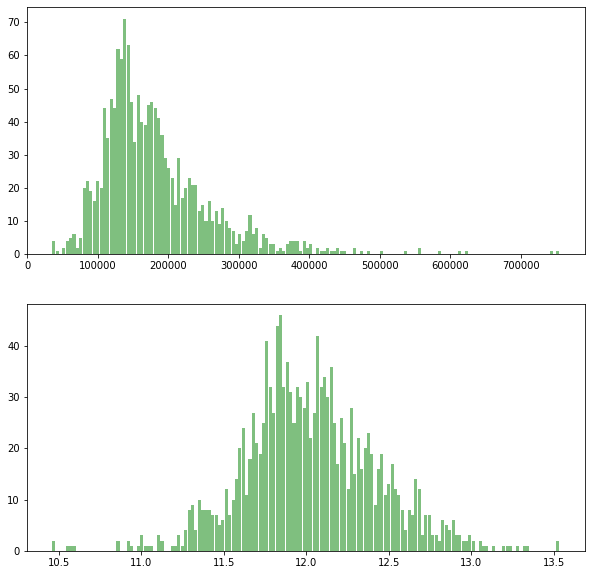

In [22]:
# 取np.log1p 真的有變比較像高斯分佈耶~ 瑪麗，太神奇了

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

fig,axes=plt.subplots(2)
fig.set_size_inches(10,10)

axes[0].hist(df_train['SalePrice'],bins=150, rwidth=0.9, color='green', alpha=0.5)
axes[1].hist(np.log1p(df_train['SalePrice']),bins=150, rwidth=0.9, color='green', alpha=0.5)

In [4]:
train_Y = np.log1p(df_train['SalePrice'])
ids = df_test['Id']
df_train = df_train.drop(['Id', 'SalePrice'] , axis=1)
df_test = df_test.drop(['Id'] , axis=1)
df = pd.concat([df_train,df_test])
df.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal


In [5]:
#只取類別值 (object) 型欄位, 存於 object_features 中
object_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'object':
        object_features.append(feature)
print(f'{len(object_features)} Object Features : {object_features}\n')

# 只留類別型欄位
df = df[object_features]
df = df.fillna('None')
train_num = train_Y.shape[0]
df.head()

43 Object Features : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']



,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


In [6]:
print(train_num)
print(df.shape[0])

1460
2919


In [7]:
# 標籤編碼 + 線性迴歸
df_temp = pd.DataFrame()
for c in df.columns:
    df_temp[c] = LabelEncoder().fit_transform(df[c])
train_X = df_temp[:train_num]
estimator = LinearRegression()
start = time.time()
print(f'shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')
print(f'time : {time.time() - start} sec')

shape : (1460, 43)
score : 0.6615606866851301
time : 0.07248854637145996 sec


In [8]:
# 獨熱編碼 + 線性迴歸
df_temp = pd.get_dummies(df)
train_X = df_temp[:train_num]
estimator = LinearRegression()
start = time.time()
print(f'shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')
print(f'time : {time.time() - start} sec')

shape : (1460, 274)
score : -1.344346963849482e+23
time : 0.542076587677002 sec


In [9]:
# 標籤編碼 + 梯度提升樹
df_temp = pd.DataFrame()
for c in df.columns:
    df_temp[c] = LabelEncoder().fit_transform(df[c])
train_X = df_temp[:train_num]
estimator = GradientBoostingRegressor()
start = time.time()
print(f'shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')
print(f'time : {time.time() - start} sec')

shape : (1460, 43)
score : 0.7773192018914813
time : 0.8050796985626221 sec


In [10]:
# 獨熱編碼 + 梯度提升樹
df_temp = pd.get_dummies(df)
train_X = df_temp[:train_num]
estimator = GradientBoostingRegressor()
start = time.time()
print(f'shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')
print(f'time : {time.time() - start} sec')

shape : (1460, 274)
score : 0.7910982579205192
time : 2.001516342163086 sec


# 作業1
* 觀察範例，在房價預測中調整標籤編碼(Label Encoder) / 獨熱編碼 (One Hot Encoder) 方式，  
對於線性迴歸以及梯度提升樹兩種模型，何者影響比較大?

# 作業2
* 鐵達尼號例題中，標籤編碼 / 獨熱編碼又分別對預測結果有何影響?